Notes:
 * revised and tuned configuration, updated views
 * training on full dataset (including Y3, new light curves, fixes)
 * trained with updated star radius estimations, multiple duplicates removed
 * removed instar examples

In [15]:
import os

chkpt_root = '/mnt/tess/astronet/checkpoints/ext_35-y2_run_1'
data_files = '/mnt/tess/astronet/tfrecords-35-y2-val/*'
tces_file = '/mnt/tess/astronet/tces-v12-y2-val.csv'

nruns = 10

def load_ensemble(chkpt_root, nruns):
    checkpts = []
    for i in range(nruns):
        parent = os.path.join(chkpt_root, str(i + 1))
        if not os.path.exists(parent):
            break
        all_dirs = os.listdir(parent)
        if not all_dirs:
            break
        d, = all_dirs
        checkpts.append(os.path.join(parent, d))
    return checkpts

paths = load_ensemble(chkpt_root, nruns)
paths

['/mnt/tess/astronet/checkpoints/ext_35-y2_run_1/1/AstroCNNModel_extended_20220326_180450',
 '/mnt/tess/astronet/checkpoints/ext_35-y2_run_1/2/AstroCNNModel_extended_20220326_184044',
 '/mnt/tess/astronet/checkpoints/ext_35-y2_run_1/3/AstroCNNModel_extended_20220326_191337',
 '/mnt/tess/astronet/checkpoints/ext_35-y2_run_1/4/AstroCNNModel_extended_20220326_194640',
 '/mnt/tess/astronet/checkpoints/ext_35-y2_run_1/5/AstroCNNModel_extended_20220326_202005',
 '/mnt/tess/astronet/checkpoints/ext_35-y2_run_1/6/AstroCNNModel_extended_20220326_205344',
 '/mnt/tess/astronet/checkpoints/ext_35-y2_run_1/7/AstroCNNModel_extended_20220326_212726',
 '/mnt/tess/astronet/checkpoints/ext_35-y2_run_1/8/AstroCNNModel_extended_20220326_220037',
 '/mnt/tess/astronet/checkpoints/ext_35-y2_run_1/9/AstroCNNModel_extended_20220326_223319',
 '/mnt/tess/astronet/checkpoints/ext_35-y2_run_1/10/AstroCNNModel_extended_20220326_230702']

In [16]:
import getpass
import os
from astronet import predict
import tensorflow as tf


def run_predictions(path):
    predict.FLAGS = predict.parser.parse_args([
      '--model_dir', path,
      '--data_files', data_files,
      '--output_file', '',
    ])

    return predict.predict()


paths = load_ensemble(chkpt_root, nruns)
ensemble_preds = []
config = None
for i, path in enumerate(paths):
    print(f'Running model {i + 1}')
    preds, config = run_predictions(path)
    ensemble_preds.append(preds.set_index('tic_id'))
    print()

Running model 1
2205 records
Running model 2
2205 records
Running model 3
2205 records
Running model 4
2205 records
Running model 5
2205 records
Running model 6
2205 records
Running model 7
2205 records
Running model 8
2205 records
Running model 9
2205 records
Running model 10
2205 records


In [17]:
labels = ['disp_e', 'disp_n', 'disp_j', 'disp_s', 'disp_b']

col_e = labels.index('disp_e')
thresh = 0.2

In [18]:
import numpy as np
import pandas as pd

agg_preds = {}

for preds in ensemble_preds:
    for tic_id in preds.index:
        if tic_id not in agg_preds:
            agg_preds[tic_id] = []

        row = preds[preds.index == tic_id]
        pred_v = row.values[0]
        if len(row.values) > 1:
            print(f'Warning: duplicate predictions for {tic_id}')
        if pred_v[col_e] >= thresh:
            agg_preds[tic_id].append('disp_e')
        else:
            masked_v = [v if i != col_e else 0 for i, v in enumerate(pred_v)]
            agg_preds[tic_id].append(preds.columns[np.argmax(masked_v)])

In [19]:
final_preds = []
for tic_id in list(agg_preds.keys()):
    counts = {l: 0 for l in labels}
    for e in agg_preds[tic_id]:
        counts[e] += 1
    maxcount = max(counts.values())
    counts.update({
        'tic_id': tic_id,
        'maxcount': maxcount,
    })
    final_preds.append(counts)
    
final_preds = pd.DataFrame(final_preds).set_index('tic_id')

In [20]:
tce_table = pd.read_csv(tces_file, header=0).set_index('tic_id')
for l in labels:
    tce_table[l] = tce_table[l[:-1] + l[-1].upper()]
tce_labels = tce_table[labels]

pl = final_preds.join(tce_labels, on='tic_id', how='left', lsuffix='_p')

pl.head()
pd.set_option('display.max_columns', None)

In [21]:
ppos = (pl['disp_e_p'] > 0)
pos = (pl['disp_e'] > 0)

pneg = (pl['disp_e_p'] == 0)
neg = (pl['disp_e'] == 0)

print('Recall:', len(pl[ppos & pos]) / len(pl[pos]))
print('Precision:', len(pl[ppos & pos]) / len(pl[ppos]))

Recall: 0.9737991266375546
Precision: 0.7216828478964401


In [22]:
for i in pl[pos & pneg][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

393324927
1715064237
199661915
28484801
369264198
158159741


In [23]:
for i in pl[neg & ppos][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

283330382
14209654
16740282
185607431
188258751
202685576
356776209
136651206
154214348
277848886
278555119
278910035
395164445
417208086
252588526
431338538
192591652
312060273
450006142
127846210
261814771
269291226
27896467
405687343
280806973
308805406
408945155
648359612
82242456
142751024
158436739
56861756
91987762
97487520
159636125
202467266
393012276
399167691
230197530
284266496
198184659
207466671
101845280
118139893
118398402
141871652
141979739
167039826
183076970
183306276
201601338
238200877
261205462
269849513
271999852
276738707
278632192
279322995
287588629
291374558
300153494
309650507
311103813
311250324
31868634
319865847
326693475
341119264
344128598
363404187
370038896
370227522
373919592
379191982
384341508
384740598
404851508
404851552
404851966
40602499
407615704
410087746
41256189
419611478
55601400
62807165


In [24]:
def compare(ensemble_preds, filter):
    result = ensemble_preds[0][filter]
    for preds in ensemble_preds[1:]:
        result = result.append(preds[filter])
    return result

compare(ensemble_preds, preds.index == 340066802)

,disp_e,disp_n,disp_j,disp_s,disp_b
tic_id,,,,,


In [25]:
pl[pl.index == 340066802]

,disp_e_p,disp_n_p,disp_j_p,disp_s_p,disp_b_p,maxcount,disp_e,disp_n,disp_j,disp_s,disp_b
tic_id,,,,,,,,,,,


### PR curve

In [26]:
tics = set(ensemble_preds[0].index.values)

tic_index = {v: i for i, v in enumerate(tics)}

pred_es = np.zeros([len(ensemble_preds), len(tic_index)])
for i, preds in enumerate(ensemble_preds):
    for row in preds.iterrows():
        tic, pred_e = row[0], row[1][col_e]
        pred_es[i][tic_index[tic]] = pred_e

lbl_es = np.zeros([len(tic_index)], dtype=np.bool)
for row in tce_labels.iterrows():
    tic, lbl_e = row[0], row[1]['disp_e']
    if tic in tic_index:
        lbl_es[tic_index[tic]] = (lbl_e > 0)

In [27]:
num_cond_pos = int(np.sum(lbl_es))

def pr_at_th(th):
    pred_pos = np.any(pred_es >= th, axis=0)
    true_pos = pred_pos & lbl_es
    num_pred_pos = int(np.sum(pred_pos))
    num_true_pos = int(np.sum(true_pos))
    if num_pred_pos == 0:
        return 1.0, 0.0
    return float(num_true_pos) / float(num_pred_pos), float(num_true_pos) / float(num_cond_pos)

AUC: 0.9738809475741924, max R: 1.0, max P: 1.0
100% recall at: 27%, threshold: 0.0030000000000546265


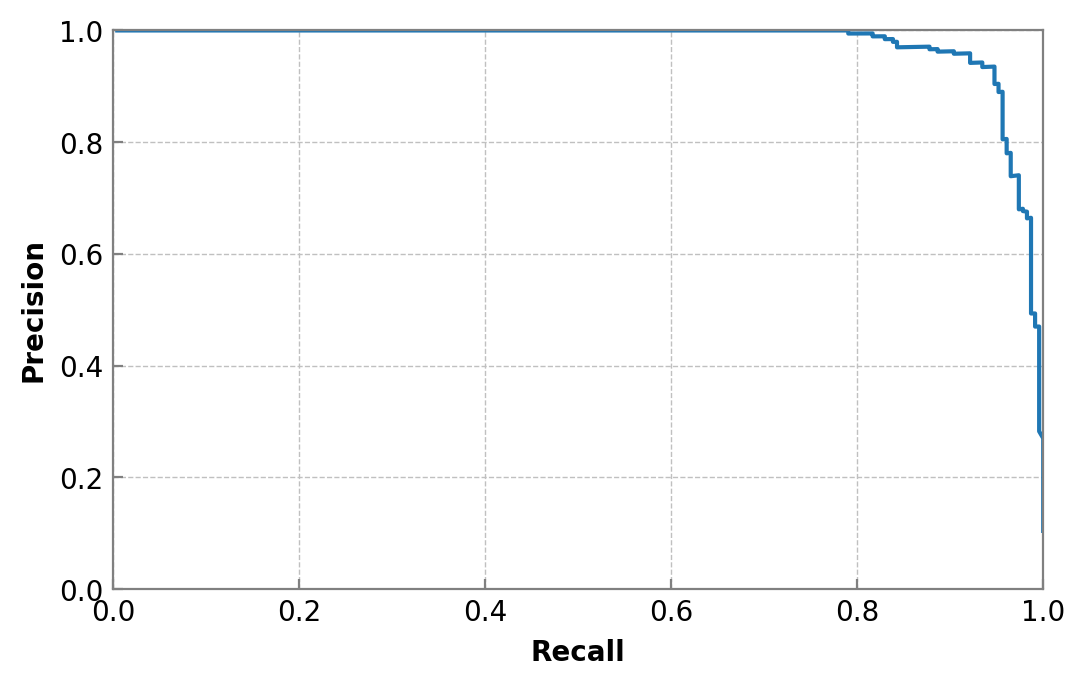

In [28]:
from matplotlib import pyplot as plt

ps, rs, ths = ([], [], [])
th = np.max(pred_es)
while th >= 0.0:
    p, r = pr_at_th(th)
    ps.append(p)
    rs.append(r)
    ths.append(th)
    th -= 0.0005
    
from sklearn import metrics

print(f'AUC: {metrics.auc(rs, ps)}, max R: {max(rs)}, max P: {max(ps)}')
    
i = len(rs) - 1
while rs[i] == 1.0:
    i -= 1
i += 1
print(f'100% recall at: {int(ps[i] * 100)}%, threshold: {ths[i]}')

fig, ax = plt.subplots(figsize=(6, 3.7), dpi=200)

ax.spines['top'].set_color('#808080')
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.spines['bottom'].set_color('#808080')
ax.tick_params(direction='in', color='#808080')

plt.grid(color='#c0c0c0', linestyle='--', linewidth=0.5)

plt.ylabel('Precision', fontweight='bold')
plt.xlabel('Recall', fontweight='bold')

plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))

_ = plt.plot(rs, ps)